各关键列缺失值数量：
Subject     0
Age         0
a_stroop    0
v_stroop    0
t_stroop    0
z_stroop    0
a_gonogo    0
v_gonogo    0
t_gonogo    0
z_gonogo    0 

清洗后剩余被试数：1122

=== 未控制年龄时的 Pearson 相关（保留三位小数） ===
a: r = 0.172, p = 0.000, d = 0.349
v: r = 0.364, p = 0.000, d = 0.783
t: r = 0.695, p = 0.000, d = 1.933
z: r = 0.088, p = 0.003, d = 0.176

=== 未控制年龄时的 Pearson 相关 BH FDR 矫正后的 p 值及显著性判断（保留三位小数，α=0.05） ===
a: 原始 p = 0.000, FDR 校正 p = 0.000, r = 0.172, d = 0.349 => 显著
v: 原始 p = 0.000, FDR 校正 p = 0.000, r = 0.364, d = 0.783 => 显著
t: 原始 p = 0.000, FDR 校正 p = 0.000, r = 0.695, d = 1.933 => 显著
z: 原始 p = 0.003, FDR 校正 p = 0.003, r = 0.088, d = 0.176 => 显著


=== 控制 Age 后的偏相关（保留三位小数） ===
a: r_partial = 0.276, p_partial = 0.000, d = 0.574
v: r_partial = 0.103, p_partial = 0.001, d = 0.207
t: r_partial = 0.680, p_partial = 0.000, d = 1.854
z: r_partial = 0.095, p_partial = 0.001, d = 0.191


=== BH FDR 矫正后的 p 值及显著性判断（保留三位小数，α=0.05） ===
a: 原始 p = 0.000, FDR 校正 p = 0.000, r_partial = 0.276, d = 0.57

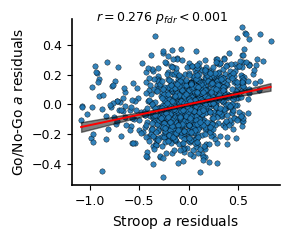

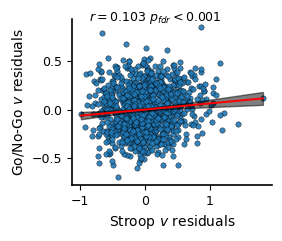

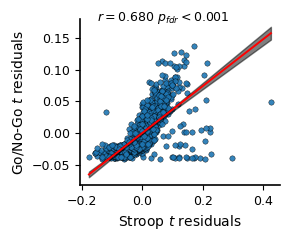

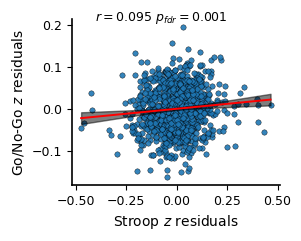

In [ ]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests

def compute_partial_corr(df, param_stroop, param_gonogo, covariate):

    X = sm.add_constant(df[covariate].astype(float))
    y_stroop = df[param_stroop].astype(float)
    model_stroop = sm.OLS(y_stroop, X).fit()
    resid_stroop = model_stroop.resid.values

    y_gonogo = df[param_gonogo].astype(float)
    model_gonogo = sm.OLS(y_gonogo, X).fit()
    resid_gonogo = model_gonogo.resid.values

    r_partial, pval_partial = pearsonr(resid_stroop, resid_gonogo)
    return r_partial, pval_partial, resid_stroop, resid_gonogo

def compute_cohens_d(r):

    d = (2 * r) / np.sqrt(1 - r**2)
    return d

def plot_partial_scatter(resid_stroop, resid_gonogo, param_label, r_value, p_raw, p_fdr):

    # 将残差数据转换为 DataFrame 以便建模
    df_resid = pd.DataFrame({
        "x": resid_stroop,
        "y": resid_gonogo
    })

    # 在回归时添加截距项
    X_resid = sm.add_constant(df_resid["x"])
    y_resid = df_resid["y"]
    model = sm.OLS(y_resid, X_resid).fit()

    # 生成用于绘制回归线和置信区间的 x 网格
    x_min, x_max = resid_stroop.min(), resid_stroop.max()
    x_vals = np.linspace(x_min, x_max, 100)
    X_pred = sm.add_constant(x_vals)
    predictions = model.get_prediction(X_pred)
    pred_summary = predictions.summary_frame(alpha=0.05)  # 95% 置信区间

    # 开始绘图
    plt.figure(figsize=(3, 2.5))
    plt.scatter(resid_stroop, resid_gonogo, s=15, alpha=0.9, edgecolor='black', linewidth=0.3)

    # 绘制回归线
    plt.plot(x_vals, pred_summary["mean"], linestyle='-', linewidth=1.4, color='red', label='Fit')

    # 绘制置信区间阴影
    plt.fill_between(x_vals, pred_summary["mean_ci_lower"], pred_summary["mean_ci_upper"],
                     color='black', alpha=0.5, label='95% CI')

    plt.xlabel(f"Stroop ${param_label}$ residuals", fontsize=10)
    plt.ylabel(f"Go/No-Go ${param_label}$ residuals", fontsize=10)

    # 标注 pFDR 文本
    if p_fdr < 0.001:
        p_fdr_display = f"$p_{{fdr}} < 0.001$"
    else:
        p_fdr_display = f"$p_{{fdr}} = {p_fdr:.3f}$"

    plt.text(
        0.75, 0.96,
        f"$r = {r_value:.3f}$ {p_fdr_display}",
        transform=plt.gca().transAxes,
        ha='right', va='bottom',
        fontsize=9,
        bbox=dict(facecolor="none", edgecolor="none", alpha=0.7)
    )

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.2)
    ax.spines['bottom'].set_linewidth(1.2)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.tick_params(axis='both', which='major', labelsize=9)

    plt.tight_layout()
    filename = f"partial_{param_label}.png"
    plt.savefig(filename, dpi=800, bbox_inches='tight')
    plt.show()

def main():
    data_path = "data.xlsx"
    if not os.path.isfile(data_path):
        raise FileNotFoundError(f"找不到文件：{data_path}，请确认文件路径和名称是否正确。")

    df = pd.read_excel(data_path, dtype={
        "Subject": str,
        "Age Group": str,
        "Incongruent": float,
        "Congruent": float,
        "Neutral": float,
        "Interference": float,
        "Age": float,
        "a_stroop": float,
        "v_stroop": float,
        "t_stroop": float,
        "z_stroop": float,
        "a_gonogo": float,
        "v_gonogo": float,
        "t_gonogo": float,
        "z_gonogo": float,
        "Go_ACC": float,
        "Nogo_ACC": float,
        "Go_RT_ms": float
    })

    required_cols = [
        "Subject", "Age",
        "a_stroop", "v_stroop", "t_stroop", "z_stroop",
        "a_gonogo", "v_gonogo", "t_gonogo", "z_gonogo"
    ]
    missing = df[required_cols].isna().sum()
    print("各关键列缺失值数量：")
    print(missing.to_string(), "\n")

    df_clean = df.dropna(subset=[
        "Age",
        "a_stroop", "v_stroop", "t_stroop", "z_stroop",
        "a_gonogo", "v_gonogo", "t_gonogo", "z_gonogo"
    ]).copy()
    df_clean.reset_index(drop=True, inplace=True)

    print(f"清洗后剩余被试数：{df_clean.shape[0]}\n")

    pairs = [
        ("a_stroop", "a_gonogo", "a"),
        ("v_stroop", "v_gonogo", "v"),
        ("t_stroop", "t_gonogo", "t"),
        ("z_stroop", "z_gonogo", "z")
    ]

    print("=== 未控制年龄时的 Pearson 相关（保留三位小数） ===")
    raw_results_list = []
    for col_st, col_go, label in pairs:
        r_raw, p_raw = pearsonr(df_clean[col_st], df_clean[col_go])
        d_raw = compute_cohens_d(r_raw)
        raw_results_list.append({
            "label": label,
            "r_raw": r_raw,
            "p_raw": p_raw,
            "d_raw": d_raw
        })
        print(f"{label}: r = {r_raw:.3f}, p = {p_raw:.3f}, d = {d_raw:.3f}")
    
    # 对未控制年龄的p值进行FDR BH校正
    p_raw_list = [item["p_raw"] for item in raw_results_list]
    _, pvals_fdr_raw, _, _ = multipletests(p_raw_list, alpha=0.05, method='fdr_bh')
    
    print("\n=== 未控制年龄时的 Pearson 相关 BH FDR 矫正后的 p 值及显著性判断（保留三位小数，α=0.05） ===")
    for item, p_fdr in zip(raw_results_list, pvals_fdr_raw):
        label = item["label"]
        r_val = item["r_raw"]
        p_raw = item["p_raw"]
        d_val = item["d_raw"]
        signif = "显著" if p_fdr < 0.05 else "不显著"
        print(f"{label}: 原始 p = {p_raw:.3f}, FDR 校正 p = {p_fdr:.3f}, r = {r_val:.3f}, d = {d_val:.3f} => {signif}")
    print("\n")

    print("=== 控制 Age 后的偏相关（保留三位小数） ===")
    results_list = []
    for col_st, col_go, label in pairs:
        r_part, p_part, resid_stroop, resid_gonogo = compute_partial_corr(
            df_clean, param_stroop=col_st, param_gonogo=col_go, covariate="Age"
        )
        d_part = compute_cohens_d(r_part)
        results_list.append({
            "label": label,
            "r_part": r_part,
            "p_part": p_part,
            "d_part": d_part,
            "resid_stroop": resid_stroop,
            "resid_gonogo": resid_gonogo
        })
        print(f"{label}: r_partial = {r_part:.3f}, p_partial = {p_part:.3f}, d = {d_part:.3f}")
    print("\n")

    p_part_list = [item["p_part"] for item in results_list]
    _, pvals_fdr, _, _ = multipletests(p_part_list, alpha=0.05, method='fdr_bh')

    print("=== BH FDR 矫正后的 p 值及显著性判断（保留三位小数，α=0.05） ===")
    for item, p_fdr in zip(results_list, pvals_fdr):
        label = item["label"]
        r_val = item["r_part"]
        p_raw = item["p_part"]
        d_val = item["d_part"]
        signif = "显著" if p_fdr < 0.05 else "不显著"
        print(f"{label}: 原始 p = {p_raw:.3f}, FDR 校正 p = {p_fdr:.3f}, r_partial = {r_val:.3f}, d = {d_val:.3f} => {signif}")
    print("\n")

    for item, p_fdr in zip(results_list, pvals_fdr):
        label = item["label"]
        r_val = item["r_part"]
        p_raw = item["p_part"]
        resid_stroop = item["resid_stroop"]
        resid_gonogo = item["resid_gonogo"]
        plot_partial_scatter(resid_stroop, resid_gonogo, label, r_val, p_raw, p_fdr)

if __name__ == "__main__":
    main()